$$ F_{\lambda}(u) = \frac{1}{2}\sum_{i=1}^{n} \left|| x_i - u_i \right||_2^2 + \lambda \sum_{j=2}^{N}\sum_{i < j} W_{ij}\left|u_i - u_j \right|_p $$

Populating the interactive namespace from numpy and matplotlib
Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-9d378adf-5823-4588-b788-ae6911ca2588
Send 'exit' command to kill the server
.......MATLAB started and connected!

/Users/kevm1892/anaconda/lib/python2.7/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)
/Users/kevm1892/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


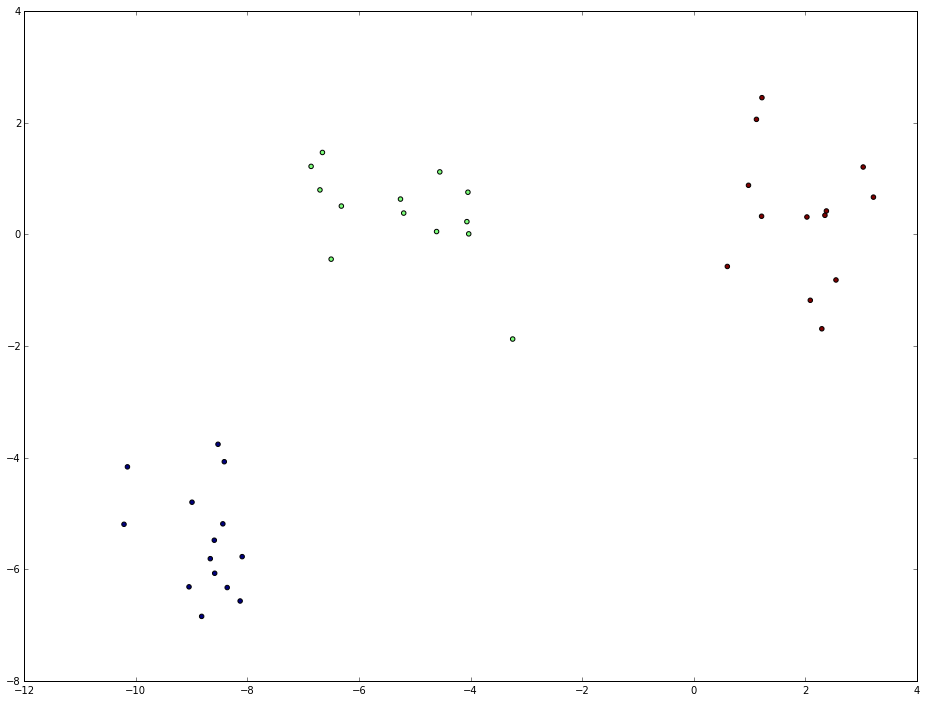

In [1]:
%pylab inline
from sklearn.datasets import make_blobs
import numpy as np
pylab.rcParams['figure.figsize'] = 16, 12 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# Initialize matlab 
import pymatbridge as pymat
ip = get_ipython()
pymat.load_ipython_extension(ip, matlab='/Applications/MATLAB_R2013a_Student.app/bin/matlab')
n_samples = 40
random_state = 170
x, y = make_blobs(n_samples=n_samples, random_state=random_state)


clf = KMeans(3)
ypred = clf.fit_predict(x)
clf.cluster_centers_
centers_dict = {i:cc for i,cc in enumerate(clf.cluster_centers_)}
scatter(x[:,0],x[:,1],c=y)
x=x.T

In [22]:
# Build W matrix
omg = 0.05
N = n_samples
d = 2 
W = asarray([map(lambda pnt:np.exp(-omg*huber(pnt)**2),x.T - \
                 np.repeat(array([x.T[j]]),N,axis=0)) for j in range(N)])

NameError: global name 'huber' is not defined

In [3]:
''' Run this first to build the proper Q matrix (efficient way to calc summation)'''

' Run this first to build the proper Q matrix (efficient way to calc summation)'

In [4]:
%%matlab -i x,N -o Q
%N = length(x);
d = 2
lambda = 0.3
%lambda = 0
p = 2
eps = 0.05

i=1;
for t=1:N
    for k=t+1:N
     Q(i,t)=1;Q(i,k)=-1;i=i+1;
    end
end



d =

     2


lambda =

    0.3000


p =

     2


eps =

    0.0500



In [5]:
# The objective/Weight building function
def obj(x,u,W,lambd):
    cnt = 0
    weight_vect = []
    norm_vect = []
    total = 0 
    N = len(u)
    print N
    # the sum of i<j can be written as
    for j in range(2,N+1):
        for i in range(1,j):
            cnt+=1
            temp = norm(u[i-1,:]-u[j-1,:])
            total+=W[i-1,j-1]*temp
            #total+=1*temp
            norm_vect.append(temp)
            weight_vect.append(W[i-1,j-1])
    total = lambd * total
    print cnt
    print total
    #total = .5 * np.sum(norm(x-u)) +total
    return total,weight_vect,norm_vect

In [7]:
''' An easy way to map the weights the proper order for the Q matrix '''
mu1 = rand(d,N) #dummy variable for objective function
[val,weights,norm_vect] = obj(x.T,mu1.T,W,1.7)
norm_vect3 = [norm(_) for _ in np.dot(Q,mu1.T)]
dict1 = {x:i for i,x in enumerate(norm_vect)}
dict2 = {x:i for i,x in enumerate(norm_vect3)}
dict1 = sorted(dict1.items(),key = lambda x:x[0])
dict2 = sorted(dict2.items(),key = lambda x:x[0])
Wkeys = [_[1] for _ in dict1]
Qkeys = [_[1] for _ in dict2]
W_to_Qmap = {j:i for i,j in zip(Wkeys,Qkeys)}
weights_Q = [weights[W_to_Qmap[i]] for i,w in enumerate(weights)]

40
780
198.911114597


In [14]:
%%matlab -i weights_Q,x,N -o mu1,mu2,Q,out
%N = length(x);
d = 2
lambda = 1.3
%lambda = 0
p = 2
eps = 0.05

i=1;
for t=1:N
    for k=t+1:N
     Q(i,t)=1;Q(i,k)=-1;i=i+1;
    end
end

%%%%%%%%%%%%% solve convex cluster formulation %%%%%%%%%%%%%
cvx_begin
variable mu1(d,N)
minimize(sum(sum((x-mu1).*(x-mu1))) ...
         +lambda*dot(weights_Q,norms(Q*mu1',2,p)))
cvx_end
%%%%% constrained least squares %%%%%%
cvx_begin
variable mu2(d,N)
minimize(sum(sum((x-mu2).*(x-mu2))))
subject to
Q(find(norms(Q*mu1',2,p)<eps),:)*mu2'==0
cvx_end
             
             

%out = lambda * dot(weights_Q,norms(Q*mu1',2,p)) %was using this for checking code


d =

     2


lambda =

    1.3000


p =

     2


eps =

    0.0500

 
Calling SDPT3 4.0: 2580 variables, 940 equality constraints
   For improved efficiency, SDPT3 is solving the dual problem.
------------------------------------------------------------

 num. of constraints = 940
 dim. of sdp    var  = 160,   num. of sdp  blk  = 80
 dim. of socp   var  = 2340,   num. of socp blk  = 780
*******************************************************************
   SDPT3: Infeasible path-following algorithms
*******************************************************************
 version  predcorr  gam  expon  scale_data
   HKM      1      0.000   1        0    
it pstep dstep pinfeas dinfeas  gap      prim-obj      dual-obj    cputime
-------------------------------------------------------------------
 0|0.000|0.000|5.7e+00|2.8e+01|6.0e+05| 8.000000e+02  0.000000e+00| 0:0:00| spchol  1  1 
 1|0.973|1.000|1.5e-01|1.4e-02|4.9e+04| 5.068732e+02 -3.654112e+04| 0:0:00| spchol  1  1 
 2|0.988|0.975|1

In [16]:
%%matlab -i W,x,N -o mu1,mu2,Q,out
%N = length(x);
d = 2
lambda = 1.3
%lambda = 0
p = 2
eps = 0.05

i=1;
for t=1:N
    for k=t+1:N
     Q(i,t)=1;Q(i,k)=-1;i=i+1;
    end
end
g = 0
h = 0
%%%%%%%%%%%%% solve convex cluster formulation %%%%%%%%%%%%%
cvx_begin
variable mu1(d,N)
for i =1:N
    g = g + sum(huber(x(:,i)-mu1(:,i)))
end
h = lambda*dot(weights_Q,norms(Q*mu1',2,p))
g = g+h
minimize(g)
cvx_end
%%%%% constrained least squares %%%%%%
cvx_begin
variable mu2(d,N)
minimize(sum(sum((x-mu2).*(x-mu2))))
subject to
Q(find(norms(Q*mu1',2,p)<eps),:)*mu2'==0
cvx_end
             
             

%out = lambda * dot(weights_Q,norms(Q*mu1',2,p)) %was using this for checking code


d =

     2


lambda =

    1.3000


p =

     2


eps =

    0.0500


g =

     0


h =

     0

 
g =
 
    cvx convex expression (scalar)
 
 
g =
 
    cvx convex expression (scalar)
 
 
g =
 
    cvx convex expression (scalar)
 
 
g =
 
    cvx convex expression (scalar)
 
 
g =
 
    cvx convex expression (scalar)
 
 
g =
 
    cvx convex expression (scalar)
 
 
g =
 
    cvx convex expression (scalar)
 
 
g =
 
    cvx convex expression (scalar)
 
 
g =
 
    cvx convex expression (scalar)
 
 
g =
 
    cvx convex expression (scalar)
 
 
g =
 
    cvx convex expression (scalar)
 
 
g =
 
    cvx convex expression (scalar)
 
 
g =
 
    cvx convex expression (scalar)
 
 
g =
 
    cvx convex expression (scalar)
 
 
g =
 
    cvx convex expression (scalar)
 
 
g =
 
    cvx convex expression (scalar)
 
 
g =
 
    cvx convex expression (scalar)
 
 
g =
 
    cvx convex expression (scalar)
 
 
g =
 
    cvx convex expression (scalar)
 
 
g =
 
    cvx convex expression (scalar)
 
 

In [19]:
%%matlab -i W,x,N -o mu1,mu2,Q,out
%N = length(x);
d = 2
lambda = 0.3
%lambda = 0
p = 2
eps = 0.05

i=1;
for t=1:N
    for k=t+1:N
     Q(i,t)=1;Q(i,k)=-1;i=i+1;
    end
end
g = 0
h = 0
%%%%%%%%%%%%% solve convex cluster formulation %%%%%%%%%%%%%
cvx_begin
variable mu1(d,N)
g = sum(sum((x-mu1).*(x-mu1)))
for j=2:N
    for i=1:j-1
        h=h + sum(W(i,j)*huber(mu1(:,i)-mu1(:,j)));
    end
end
g = g+h;
minimize(g)
cvx_end
%%%%% constrained least squares %%%%%%
cvx_begin
variable mu2(d,N)
minimize(sum(sum((x-mu2).*(x-mu2))))
subject to
Q(find(norms(Q*mu1',2,p)<eps),:)*mu2'==0
cvx_end
             
             

%out = lambda * dot(weights_Q,norms(Q*mu1',2,p)) %was using this for checking code


d =

     2


lambda =

    0.3000


p =

     2


eps =

    0.0500


g =

     0


h =

     0

 
g =
 
    cvx convex expression (scalar)
 
 
Calling SDPT3 4.0: 14280 variables, 6320 equality constraints
------------------------------------------------------------

 num. of constraints = 6320
 dim. of sdp    var  = 3280,   num. of sdp  blk  = 1640
 dim. of socp   var  = 3120,   num. of socp blk  = 1560
 dim. of linear var  = 6240
*******************************************************************
   SDPT3: Infeasible path-following algorithms
*******************************************************************
 version  predcorr  gam  expon  scale_data
   HKM      1      0.000   1        0    
it pstep dstep pinfeas dinfeas  gap      prim-obj      dual-obj    cputime
-------------------------------------------------------------------
 0|0.000|0.000|2.0e+02|1.3e+02|5.6e+08| 1.677041e+06  0.000000e+00| 0:0:00| spchol  1  1 
 1|0.161|0.131|1.7e+02|1.1e+02|5.3e+08| 3.183178e+06 -3.03339

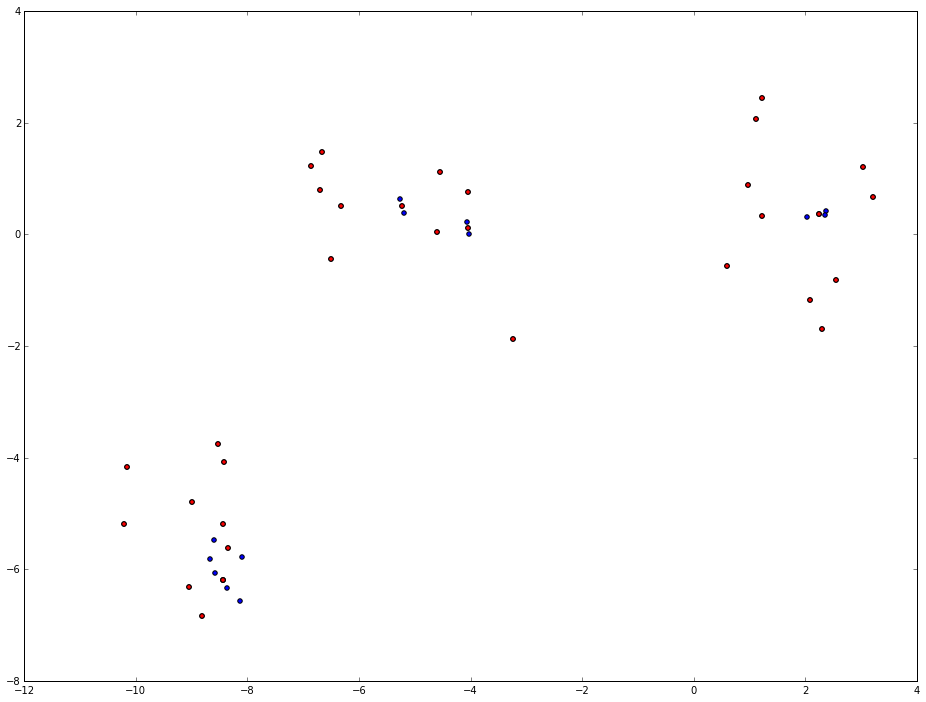

In [21]:
scatter(x.T[:,0],x.T[:,1])
scatter(mu2.T[:,0],mu2.T[:,1],c='r')

In [ ]:
shape(Q)